In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ARDRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import boxcox

In [233]:
# Пример данных
df = pd.read_csv('regional_data/infl_Российская_Федерация.csv')
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.drop('Date', axis=1, inplace=True)
df.head(3)

,paid_services,salary,debt_firms,debt_fiz,trade_turnover,money_income,inflation,fm_changes_volume,fm_changes_costs,fm_changes_demand,fm_volume_exp,fm_demand_exp,fm_price_exp,Brent,MIACR,Infl_exp,M2,gov_debt,obligates,unemployment
0,559456677.90,29535.00,18171671,9708233,179896.00,25631.04,100.39,-33.64,16.55,-19.00,19.52,17.86,13.97,108.12,6.06,13.04,31155.60,5722.24,6.20,6.80
1,571950883.80,29255.30,18184819,9821423,179896.00,25631.04,100.49,0.24,19.85,-5.42,22.33,20.61,16.51,108.90,5.99,11.80,29861.20,5733.57,6.39,6.80
2,591568267.20,31485.90,18458002,9964305,179896.00,25631.04,100.82,10.32,21.99,0.58,21.65,20.25,14.31,107.48,7.85,11.52,30169.00,5754.95,7.40,6.80


In [224]:
df = df.apply(lambda x: x.diff(1)[1:])
# df1 = df.apply(lambda x: boxcox(x - x.min() + 1)[0])
# df1 = df.apply(lambda x: np.log(x - x.min() + 1))
# df = df.apply(lambda x: x.diff(1)[1:])
# df1.apply(lambda x: adfuller(x)[1] < 0.05)
df.apply(lambda x: adfuller(x)[1] < 0.05)



paid_services         True
salary               False
debt_firms           False
debt_fiz             False
trade_turnover       False
money_income         False
inflation             True
fm_changes_volume     True
fm_changes_costs      True
fm_changes_demand     True
fm_volume_exp         True
fm_demand_exp         True
fm_price_exp          True
Brent                 True
MIACR                 True
Infl_exp              True
M2                   False
gov_debt              True
obligates             True
unemployment          True
dtype: bool

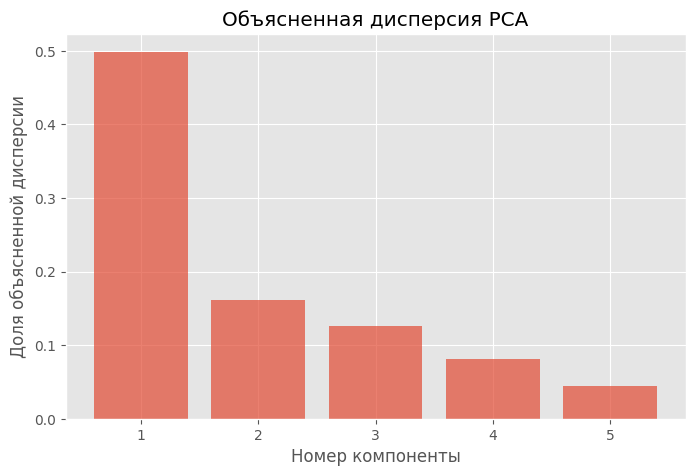

In [248]:
y = df["inflation"]  
X = df.drop(columns=["inflation"])  

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
loadings = pca.components_

# Визуализация объясненной дисперсии компонентами  PCA
plt.figure(figsize=(8, 5), dpi=100)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.xlabel('Номер компоненты')
plt.ylabel('Доля объясненной дисперсии')
plt.title('Объясненная дисперсия PCA')
plt.show()

<Axes: >

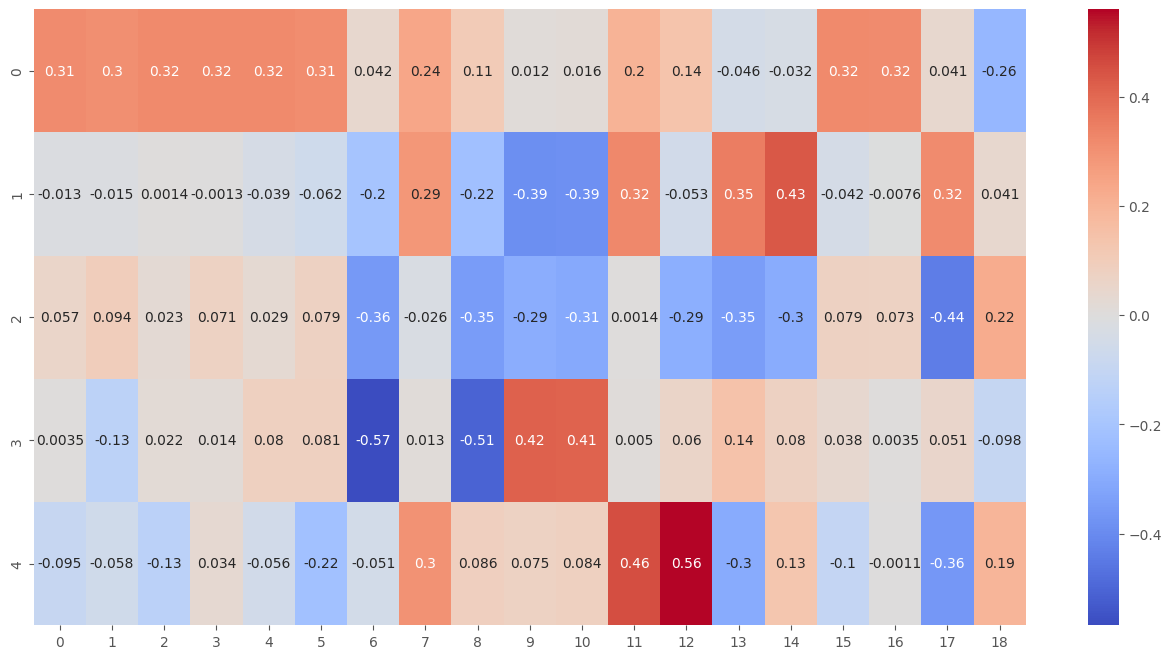

In [246]:
plt.figure(figsize=(16, 8))
sb.heatmap(loadings, annot=True, cmap='coolwarm')


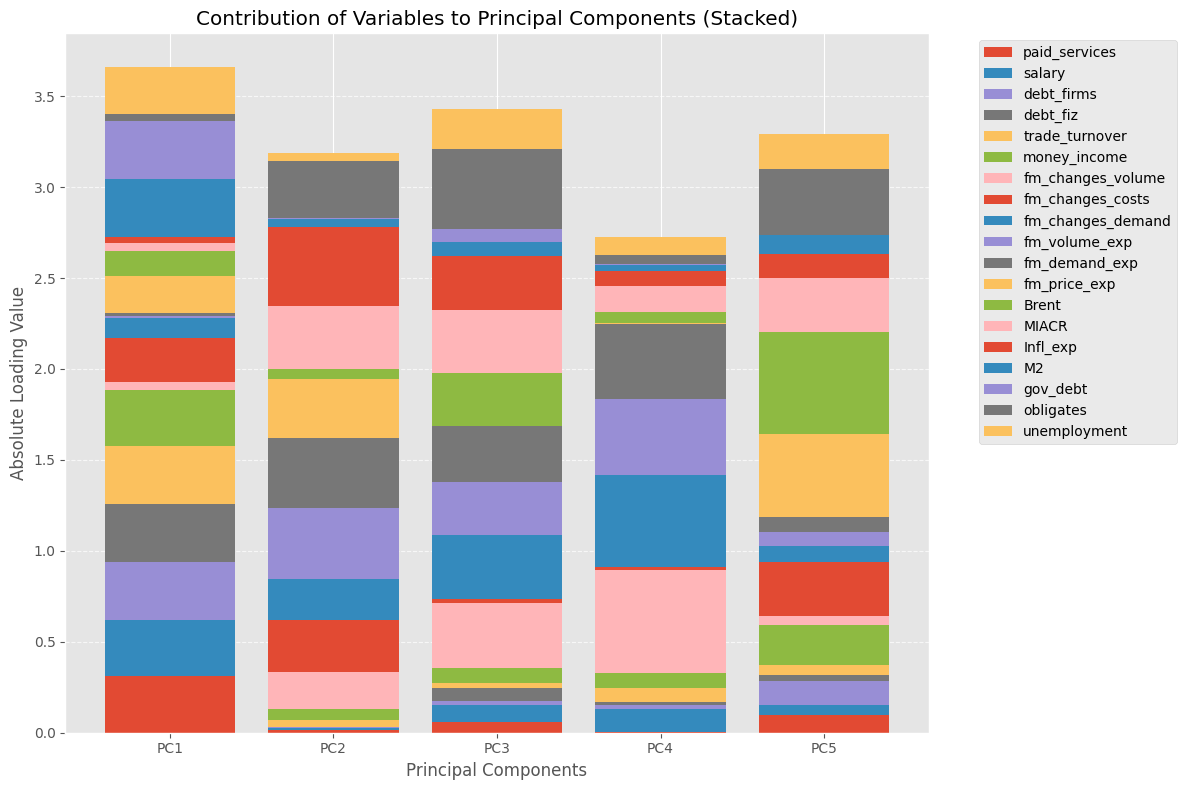

In [189]:
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что у вас уже есть:
# - loadings: матрица весов компонент PCA (shape: [n_components, n_features])
# - X: исходный DataFrame с признаками (до удаления колонок)

# Получаем названия признаков
feature_names = X.columns

# Создаем figure и axes
plt.figure(figsize=(12, 8))

# Для каждой компоненты собираем абсолютные значения весов (вклад признаков)
n_components = pca.n_components_
n_features = len(feature_names)

# Создаем stacked bar chart
bottom = np.zeros(n_components)  # для накопления высот

# Для каждого признака рисуем его вклад во все компоненты
for i, feature in enumerate(feature_names):
    contributions = np.abs(loadings.T[i][:n_components])  # берем абсолютные значения весов
    plt.bar(range(n_components), contributions, label=feature, bottom=bottom)
    bottom += contributions

# Настройки графика
plt.xlabel('Principal Components')
plt.ylabel('Absolute Loading Value')
plt.title('Contribution of Variables to Principal Components (Stacked)')
plt.xticks(range(n_components), [f'PC{i+1}' for i in range(n_components)])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

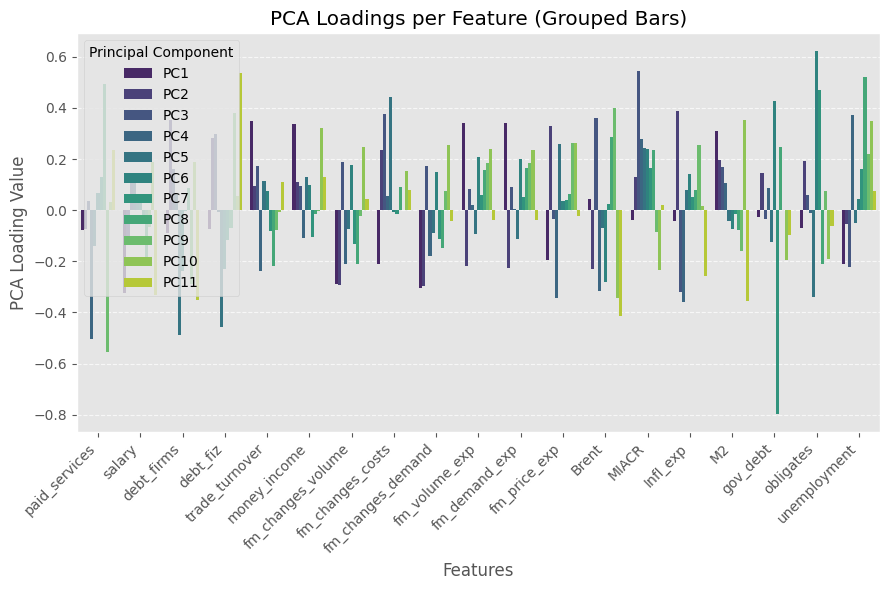

In [226]:
import seaborn as sns
import pandas as pd
feature_names = X.columns
pc_names = [f'PC{i+1}' for i in range(pca.n_components_)]
# loadings_abs = np.abs(pca.components_)
loadings_abs = pca.components_


# Преобразуем loadings в DataFrame
loadings_df = pd.DataFrame(
    loadings_abs.T,  # Транспонируем, чтобы строки = признаки, столбцы = компоненты
    index=feature_names,
    columns=pc_names
).reset_index().melt(id_vars='index', var_name='PC', value_name='Loading')

# Переименуем колонки
loadings_df.columns = ['Feature', 'PC', 'Loading']

# Строим график
plt.figure(figsize=(9, 6))
sns.barplot(
    data=loadings_df,
    x='Feature',
    y='Loading',
    hue='PC',
    palette='viridis'  # Можно выбрать другую палитру
)

plt.title('PCA Loadings per Feature (Grouped Bars)')
plt.xlabel('Features')
plt.ylabel('PCA Loading Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Principal Component', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                            AutoReg Model Results                             
Dep. Variable:              inflation   No. Observations:                  117
Model:                   AutoReg-X(1)   Log Likelihood                 -72.322
Method:               Conditional MLE   S.D. of innovations              0.451
Date:                Tue, 08 Apr 2025   AIC                            172.644
Time:                        15:45:43   BIC                            211.194
Sample:                             1   HQIC                           188.293
                                  117                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.042      0.150      0.881      -0.076       0.088
inflation.L1    -0.4052      0.043     -9.487      0.000      -0.489      -0.322
x1              -0.0121      0.017     -0.69

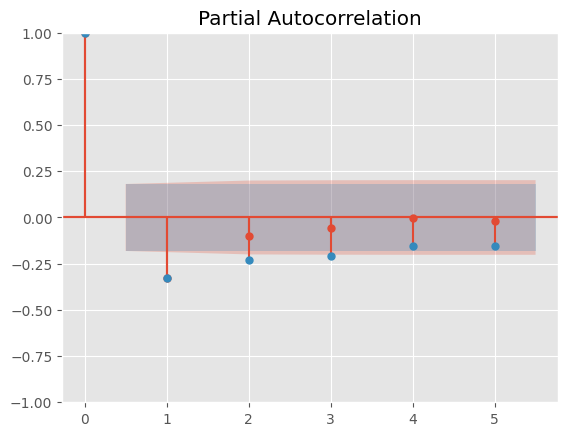

In [227]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y, lags=5, ax=plt.gca())  # lags=20 - количество лагов для отображения
plot_pacf(y, lags=5, ax=plt.gca(), method='ols')  # method='ols' для PACF

# Построение ARDL модели
model = AutoReg(y, lags=1, exog=X_pca)
results = model.fit()
result= results.summary()
print(result)

In [217]:
import pandas as pd

# Данные из модели
pca_weights = pca.components_  # Веса компонент (n_components × n_features)
ardl_coefs = results.params.iloc[2:]  # Коэффициенты при PC1, PC2,... (игнорируем константу и лаги)

# Стандартные отклонения исходных переменных
X_std = np.sqrt(scaler.var_)

# Считаем влияние каждой переменной
effects = []
for feature_idx, feature_name in enumerate(X.columns):
    total_effect = 0
    for pc_idx in range(pca.n_components_):
        # Вклад feature в PC
        weight = pca_weights[pc_idx, feature_idx]
        # Коэффициент при PC в ARDL
        coef = ardl_coefs[f"x{pc_idx}"] if f"x{pc_idx}" in ardl_coefs else 0
        # Добавляем в общий эффект
        total_effect += 100 * (coef * weight) / X_std[feature_idx]
    effects.append(total_effect)

# Результаты
effect_df = pd.DataFrame({"Переменная": X.columns, "Влияние на инфляцию": effects})
effect_df

,Переменная,Влияние на инфляцию
0,paid_services,0.00
1,salary,0.00
2,debt_firms,-0.00
3,debt_fiz,0.00
4,trade_turnover,-0.00
5,money_income,-0.00
6,fm_changes_volume,-0.24
7,fm_changes_costs,0.33
8,fm_changes_demand,-0.22
9,fm_volume_exp,-1.42


In [75]:
from statsmodels.tsa.ar_model import AutoReg

# Добавляем константу (intercept)
X_sm = sm.add_constant(X_pca)

# OLS-регрессия
model_ols = sm.OLS(y, X_sm)
results_ols = model_ols.fit()

print(results_ols.summary())

# Остатки модели
residuals = results_ols.resid

# Оцениваем AR(p) для остатков
ar_order = 1  # порядок авторегрессии (можно подобрать через AIC)
model_ar = AutoReg(residuals, lags=ar_order)
results_ar = model_ar.fit()

# Прогнозируем AR-ошибки
ar_predictions = results_ar.predict()

# Корректируем исходные данные
y_corrected = y - ar_predictions

# Переоцениваем OLS на скорректированных данных
model_ols_corrected = sm.OLS(y_corrected[1:], X_sm[1:])
results_ols_corrected = model_ols_corrected.fit()
print(results_ols_corrected.summary())

                            OLS Regression Results                            
Dep. Variable:               infl_rus   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     13.58
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           1.35e-10
Time:                        12:08:43   Log-Likelihood:                -141.32
No. Observations:                 132   AIC:                             294.6
Df Residuals:                     126   BIC:                             311.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6057      0.063      9.632      0.0

In [76]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(X) модель: порядок (1,0,0) = AR(1)
model_arima = ARIMA(y, exog=X_pca, order=(1, 0, 0))
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:               infl_rus   No. Observations:                  132
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -121.869
Date:                Mon, 07 Apr 2025   AIC                            259.738
Time:                        12:09:29   BIC                            282.801
Sample:                             0   HQIC                           269.110
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3457      1.273      0.272      0.786      -2.149       2.840
x1            -0.5082      0.402     -1.264      0.206      -1.296       0.280
x2             1.0497      0.180      5.831      0.0